In [3]:
# LIVE CONSO – 7 DERNIERS JOURS (energy_consumption_hourly_live)

import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML

# ── Connexion DB ─────────────────────────────────────
conn = psycopg2.connect(
    host=os.getenv('GAUSSDB_HOST', 'localhost'),
    port=os.getenv('GAUSSDB_PORT', '5432'),
    dbname=os.getenv('GAUSSDB_DB_SILVER', 'silver'),
    user=os.getenv('GAUSSDB_USER', 'postgres'),
    password=os.getenv('GAUSSDB_PASSWORD', 'postgres')
)

# ── Chargement des 7 derniers jours (live) ─────────────────────
df = pd.read_sql("SELECT * FROM energy_consumption_hourly_live ORDER BY time_ts", conn)
conn.close()

df['time_ts'] = pd.to_datetime(df['time_ts'])
print(f"Chargé : {len(df)} lignes → du {df['time_ts'].min().strftime('%Y-%m-%d %H:%M')} au {df['time_ts'].max().strftime('%Y-%m-%d %H:%M')}")

Chargé : 3638 lignes → du 2025-11-11 02:00 au 2025-11-19 23:00


C:\Users\hamza\AppData\Local\Temp\ipykernel_29760\3650254835.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM energy_consumption_hourly_live ORDER BY time_ts", conn)


In [4]:
# ── Stats globales sur les 7 jours ─────────────────────────────
stats = {
    'Période': f"{df['time_ts'].min().strftime('%Y-%m-%d')} → {df['time_ts'].max().strftime('%Y-%m-%d')}",
    'Nombre d\'heures': len(df),
    'Consommation totale': f"{df['use_kw'].sum():,.1f} kWh",
    'Consommation moyenne par heure': f"{df['use_kw'].mean():.2f} kW",
    'Consommation moyenne par jour': f"{df['use_kw'].mean() * 24:.1f} kWh/jour",
    'Pic de consommation (max horaire)': f"{df['use_kw'].max():.2f} kW",
    'Consommation minimale (min horaire)': f"{df['use_kw'].min():.2f} kW",
}

display(HTML("<h3>LIVE – Consommation des 7 derniers jours</h3>"))
pd.Series(stats).to_frame('Valeur')

,Valeur
Période,2025-11-11 → 2025-11-19
Nombre d'heures,3638
Consommation totale,"16,942.5 kWh"
Consommation moyenne par heure,4.66 kW
Consommation moyenne par jour,111.8 kWh/jour
Pic de consommation (max horaire),24.93 kW
Consommation minimale (min horaire),0.58 kW


In [5]:
# ── Stats par jour (max, min, moyenne, total) ─────────────────────
df_day = df.copy()
df_day['jour'] = df_day['time_ts'].dt.date

daily = df_day.groupby('jour')['use_kw'].agg([
    ('max_kwh', 'max'),
    ('min_kwh', 'min'),
    ('moyenne_kwh', 'mean'),
    ('total_kwh', 'sum')
]).round(2)

daily = daily.reset_index()
daily = daily.sort_values('jour', ascending=False)

display(HTML("<h3>Par jour – MAX • MIN • MOYENNE • TOTAL</h3>"))
daily_styled = daily.style\
    .format({'max_kwh': '{:.1f}', 'min_kwh': '{:.1f}', 'moyenne_kwh': '{:.1f}', 'total_kwh': '{:.1f}'})\
    .background_gradient(subset=['total_kwh'], cmap='Reds')\
    .background_gradient(subset=['max_kwh'], cmap='Oranges')\
    .set_caption("7 derniers jours complets")

display(daily_styled)

,jour,max_kwh,min_kwh,moyenne_kwh,total_kwh
8,2025-11-19,24.0,0.6,4.7,1898.0
7,2025-11-18,23.9,0.6,4.7,1900.0
6,2025-11-17,23.0,0.6,4.6,1892.0
5,2025-11-16,23.9,0.6,4.5,1817.5
4,2025-11-15,23.0,0.6,4.5,1821.2
3,2025-11-14,24.9,0.6,4.7,1918.6
2,2025-11-13,22.9,0.6,4.7,1933.7
1,2025-11-12,22.7,0.6,4.8,1976.3
0,2025-11-11,22.4,0.6,4.8,1785.2


In [22]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML

# ── Connexion DB ─────────────────────────────────────
conn = psycopg2.connect(
    host=os.getenv('GAUSSDB_HOST', 'localhost'),
    port=os.getenv('GAUSSDB_PORT', '5432'),
    dbname=os.getenv('GAUSSDB_DB_SILVER', 'silver'),
    user=os.getenv('GAUSSDB_USER', 'postgres'),
    password=os.getenv('GAUSSDB_PASSWORD', 'postgres')
)

# ── Charger toutes les prédictions solaires 7j ───────
solar_df = pd.read_sql("""
    SELECT *
    FROM predicted_solar_production
    ORDER BY timestamp
""", conn)

conn.close()

solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])

print(f"Chargé : {len(solar_df)} lignes")
print(f"De : {solar_df['timestamp'].min()} → {solar_df['timestamp'].max()}")
display(solar_df.head())


Chargé : 165 lignes
De : 2025-11-13 03:00:00+00:00 → 2025-11-19 23:00:00+00:00


C:\Users\hamza\AppData\Local\Temp\ipykernel_29760\172278720.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solar_df = pd.read_sql("""


,timestamp,temperature_c,humidity_pct,cloud_cover_pct,solar_radiation_w_m2,ghi_w_m2,dni_w_m2,dhi_w_m2,cell_temperature_c,dc_power_kw,ac_power_kw,predicted_production_kwh
0,2025-11-13 03:00:00+00:00,19.0,50.0,100.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
1,2025-11-13 04:00:00+00:00,19.0,50.0,100.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
2,2025-11-13 05:00:00+00:00,19.1,50.0,100.0,0.0,0.0,0.0,0.0,19.1,0.0,0.0,0.0
3,2025-11-13 06:00:00+00:00,19.9,50.0,100.0,0.0,0.0,0.0,0.0,19.9,0.0,0.0,0.0
4,2025-11-13 07:00:00+00:00,18.8,50.0,100.0,0.0,0.0,0.0,0.0,18.8,0.0,0.0,0.0


In [24]:
# Ajouter la colonne date (jour sans l'heure)
solar_df['date'] = solar_df['timestamp'].dt.date

# Total sur 7 jours
total_kwh = solar_df['predicted_production_kwh'].sum()

# Stats journalières
daily_stats = (
    solar_df.groupby('date')['predicted_production_kwh']
    .sum()
    .reset_index()
    .rename(columns={'predicted_production_kwh': 'total_kwh'})
)

print(f"⚡ Énergie totale prévue (7j) : {total_kwh:.1f} kWh")
display(daily_stats)


⚡ Énergie totale prévue (7j) : 15965.5 kWh


,date,total_kwh
0,2025-11-13,832.738057
1,2025-11-14,3070.978264
2,2025-11-15,2339.233033
3,2025-11-16,1913.336394
4,2025-11-17,2393.628089
5,2025-11-18,2296.081180
6,2025-11-19,3119.526377


2025-11-14 24


,timestamp,predicted_production_kwh,ghi_w_m2,solar_radiation_w_m2,cloud_cover_pct
21,2025-11-14 00:00:00+00:00,0.0,0.0,0.0,98.0
22,2025-11-14 01:00:00+00:00,0.0,0.0,0.0,93.0
23,2025-11-14 02:00:00+00:00,0.0,0.0,0.0,100.0
24,2025-11-14 03:00:00+00:00,0.0,0.0,0.0,90.0
25,2025-11-14 04:00:00+00:00,0.0,0.0,0.0,46.0


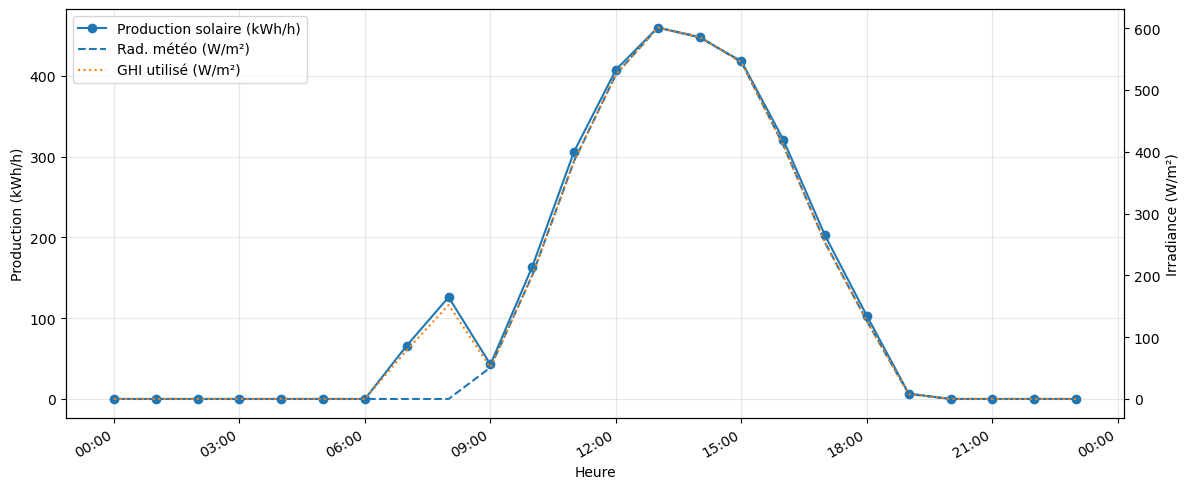

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# On suppose que solar_df est déjà chargé
solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])
solar_df['date'] = solar_df['timestamp'].dt.date

# Choisir un jour à inspecter
day = pd.to_datetime('2025-11-14').date()
day_df = solar_df[solar_df['date'] == day].copy()

print(day, len(day_df))
display(day_df[['timestamp', 'predicted_production_kwh', 'ghi_w_m2', 'solar_radiation_w_m2', 'cloud_cover_pct']].head())

# ── Plot prod vs GHI & solar_radiation ──────────────────────────────
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(day_df['timestamp'], day_df['predicted_production_kwh'], marker='o', label='Production solaire (kWh/h)')
ax1.set_xlabel("Heure")
ax1.set_ylabel("Production (kWh/h)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(day_df['timestamp'], day_df['solar_radiation_w_m2'], linestyle='--', label='Rad. météo (W/m²)')
ax2.plot(day_df['timestamp'], day_df['ghi_w_m2'], linestyle=':', label='GHI utilisé (W/m²)')
ax2.set_ylabel("Irradiance (W/m²)")

# Format de l’axe des dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()

# Légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
# Groupement par jour
daily_stats = (
    cons_df
    .groupby('date')['use_kw']
    .agg(
        total_kwh='sum',   # énergie totale de la journée
        mean_kw='mean',    # puissance moyenne
        max_kw='max',      # pic horaire max
        min_kw='min'       # minimum horaire
    )
    .reset_index()
)

# Petit tri par date au cas où
daily_stats = daily_stats.sort_values('date')

print("✅ Statistiques journalières de consommation")
display(daily_stats)

print("\n🔎 Résumé rapide :")
print(f"- Conso journalière moyenne : {daily_stats['total_kwh'].mean():.1f} kWh/j")
print(f"- Conso journalière max     : {daily_stats['total_kwh'].max():.1f} kWh/j")
print(f"- Conso journalière min     : {daily_stats['total_kwh'].min():.1f} kWh/j")


✅ Statistiques journalières de consommation


,date,total_kwh,mean_kw,max_kw,min_kw
0,2025-11-11,1785.1743,4.773193,22.3823,0.6127
1,2025-11-12,1976.2894,4.843847,22.7193,0.6159
2,2025-11-13,1936.4068,4.746095,23.2721,0.6074
3,2025-11-14,1913.6126,4.690227,23.6086,0.6175
4,2025-11-15,1821.9531,4.465571,23.2076,0.5897
5,2025-11-16,1818.5240,4.457167,22.7942,0.6125
6,2025-11-17,1898.7537,4.653808,22.8914,0.6077
7,2025-11-18,1892.6950,4.638958,22.6495,0.6024
8,2025-11-19,1895.6544,4.646212,24.3413,0.6015



🔎 Résumé rapide :
- Conso journalière moyenne : 1882.1 kWh/j
- Conso journalière max     : 1976.3 kWh/j
- Conso journalière min     : 1785.2 kWh/j
